# Project 4 [Facial Keypoints Detection](https://www.kaggle.com/c/facial-keypoints-detection/discussion) Baseline Model

## W207 Applied Machine Learning
## Group members: Julia Ying, Haerang Lee, Sang-hyeb Lee
## Date: March/14/2020



# 0. Setup

tf version: 2.2.0-rc2
pandas version: 1.0.3
keras version: 2.3.0-tf


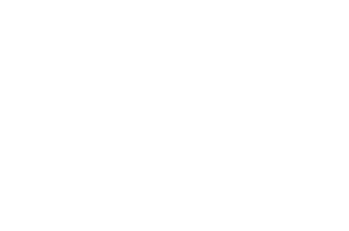

In [0]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import transform
from skimage.transform import AffineTransform
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer

print(f"tf version: {tf.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"keras version: {keras.__version__}")
%matplotlib inline
plt.style.use('ggplot')
plt.axis('off')
plt.rcParams['figure.figsize'] = [15, 15]
IMAGE_WIDTH = 96
np.random.seed(0)

# 1. Download data from Kaggle & mount google drive

In [0]:
# mount google drive at /content/drive
from google.colab import drive
drive.mount("/content/drive")

!pip install kaggle   #install kaggle library
!mkdir ~/.kaggle         #make a directory named .kaggle 
!cp /content/drive/My\ Drive/Kaggle/kaggle.json ~/.kaggle/ #copy the personal kaggle authentication key 
!ls ~/.kaggle/*
!chmod 600 ~/.kaggle/kaggle.json  
!kaggle datasets list
!kaggle competitions download -c facial-keypoints-detection

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
mkdir: cannot create directory ‘/root/.kaggle’: File exists
/root/.kaggle/kaggle.json
ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 2. Exploratory Data Analysis

In [0]:
# load data
train_data_df = pd.read_csv("training.zip")
test_data_df = pd.read_csv("test.zip")
meta_data_df = pd.read_csv("IdLookupTable.csv")

In [0]:
# let's look at train data set
train_data_df.info()
train_data_df.head(5).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


There are 31 columns in this dataset. Each column except the last one represents a facial feature point as a float in given diemsion. Last column contains image dataset as a string. Let's check if there is any missing dataset

In [0]:
print(train_data_df.isnull().any().value_counts())
train_data_df.columns[train_data_df.isnull().any()]

True     28
False     3
dtype: int64


Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'mouth_left_corner_x',
       'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y',
       'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'],
      dtype='object')

Out of 31 columns, there are 28 columns which have missing values.


In [0]:
# find out number of number of rows with missing values
print(f"Total number of rows: {train_data_df.shape[0]}")
print(f"Total number of rows with NaN : {train_data_df.shape[0] - train_data_df.dropna().shape[0]}")

Total number of rows: 7049
Total number of rows with NaN : 4909


There are `4909` rows with missing values. It looks like there are two groups of features in the dataset. First group of features have the number of rows between 7016 ~ 7049. These are `left_eye_center_x `, `left_eye_center_y`, `right_eye_center_x`, `right_eye_center_y`, `mouth_center_bottom_lip_x`, and `mouth_center_bottom_lip_y`. Second group of features have the number of rows between 2225 ~ 2275. These are corner key points.

Training dataset is not missing data at random, and the earlier rows have all the data points, the latter rows have some data missing. 


# 3. Data Preprocessing

In [0]:
# helper function for displaying images with facial points
# key_point represents the original facial key points
# new_key_points represents the facial key points after data preprocessing
image_show_random_seed = 5
def show_image_with_key_points(img: np.ndarray, key_points: np.ndarray, 
                              image_number, axis, new_key_points: np.ndarray = None):
  axis.axis('off')
  axis.imshow(img[:,:,0],cmap="gray")
  if new_key_points is not None:
    axis.scatter(new_key_points[0:30:2],new_key_points[1:30:2], s=20,marker=',',c='pink')
  axis.scatter(key_points[0:30:2],key_points[1:30:2], s=20,marker=',',c='red')
  axis.set_title(f"Image: {image_number}")

def show_multiple_samples( image_set: np.ndarray, feature_set: np.ndarray, 
                          new_feature_set: np.ndarray, number_of_images: int, images_per_row = 3,
                          image_random_seed = image_show_random_seed,fig_title: str=None):
  fig, axis = plt.subplots(number_of_images//images_per_row, images_per_row)
  if fig_title is not None:
    fig.suptitle(fig_title, fontsize=25)
  np.random.seed(image_random_seed)
  for i in range(number_of_images):
    image_number = np.random.randint(0, image_set.shape[0])
    show_image_with_key_points(image_set[image_number], feature_set[image_number], 
                              image_number , axis[i//images_per_row,
                                                  i%images_per_row],
                               new_feature_set[image_number] if new_feature_set is not None else None)
  fig.tight_layout()
  fig.subplots_adjust(top=0.88)

## Convert data into numpy format and split it into (test/validation) sets 

Out of 7049 dataset
5991 rows have been allocated for training.
1783 rows have been allocated for testing.


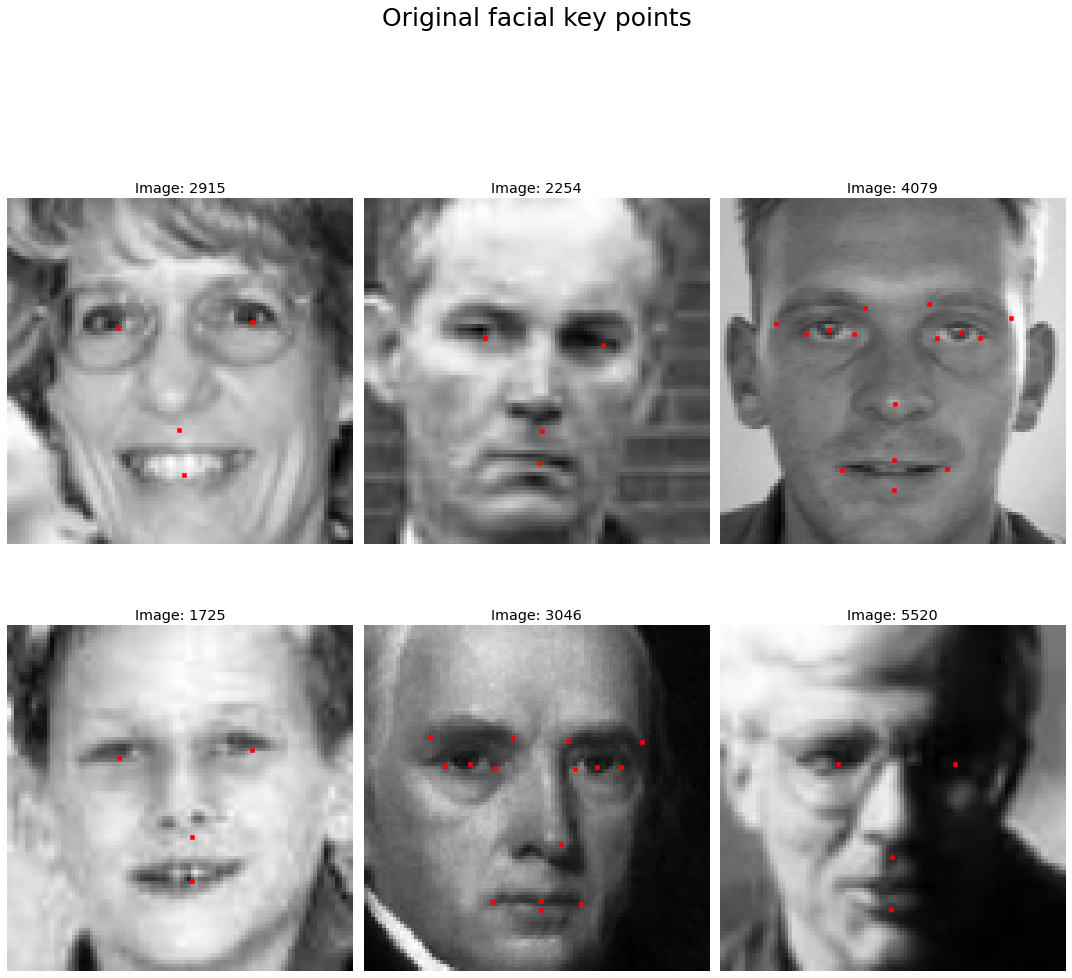

In [0]:
# As discovered in explortatory data analysis set, the the earlier rows have all the data points 
# whereas the latter rows have some data missing. Let's shuffle the dataset 
# so that the dev set does not end up with only rows with missing data. 
shuffled_train_df = train_data_df.sample(frac=1, random_state=12345)

# Let's convert data into 2d
def convert_df_to_np_2d(df: pd.Series, image_size: int) -> np.ndarray:
  dataset = np.hstack(df.apply(lambda row:np.fromstring(row,sep=' ')).to_numpy())
  dataset = dataset.astype(np.float32)
  dataset = dataset.reshape(-1,image_size,image_size,1)
  return dataset

# As discovered in explortatory data analysis set, the the earlier rows have all the data points 
# whereas the latter rows have some data missing. Let's shuffle the dataset 
# so that the dev set does not end up with only rows with missing data. 
train_data_np = convert_df_to_np_2d(shuffled_train_df["Image"], IMAGE_WIDTH)
train_label_np = np.delete(shuffled_train_df.to_numpy(),-1,axis=1).astype(np.float32) #removing the last column(Image)
X_train, X_dev, y_train, y_dev = train_test_split(train_data_np, train_label_np, shuffle= False, train_size = 0.85)
X_test = convert_df_to_np_2d(test_data_df["Image"], IMAGE_WIDTH)
print(f"Out of {train_data_np.shape[0]} dataset")
print(f"{X_train.shape[0]} rows have been allocated for training.")
print(f"{X_test.shape[0]} rows have been allocated for testing.")

show_multiple_samples(X_train,y_train, None, 6,fig_title="Original facial key points")


## Fill the missing value using the neighbor values

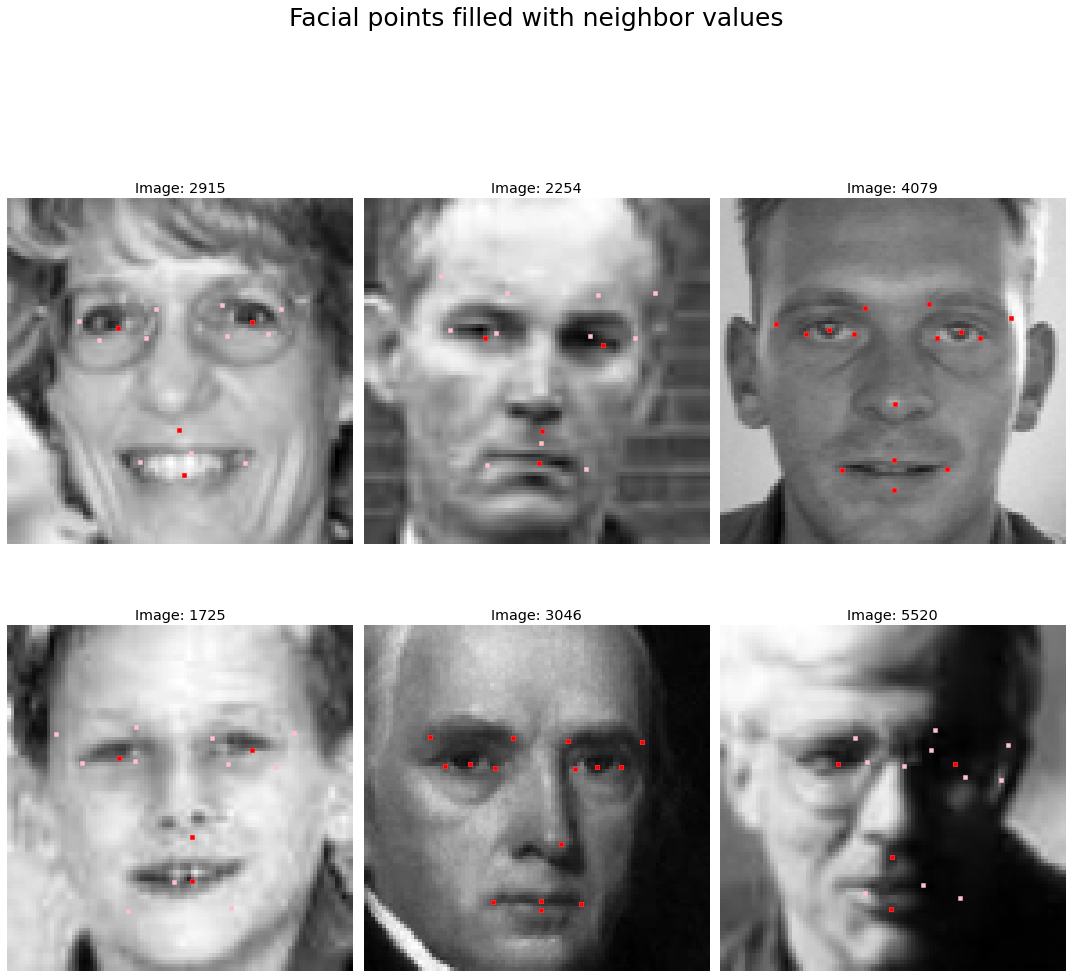

In [0]:
# fill in both ways in case the first item is empty
shuffled_train_ff_df = shuffled_train_df.copy()
shuffled_train_ff_df.fillna(method="ffill", inplace = True)
shuffled_train_ff_df.fillna(method="bfill", inplace = True)

train_label_ff_np = np.delete(shuffled_train_ff_df.to_numpy(),-1,axis=1).astype(np.float32)
y_train_ff, y_dev_ff = train_test_split(train_label_ff_np, shuffle= False, train_size = 0.85)
show_multiple_samples(X_train,y_train, y_train_ff, 6, fig_title="Facial points filled with neighbor values")

## Fill missing value using median 

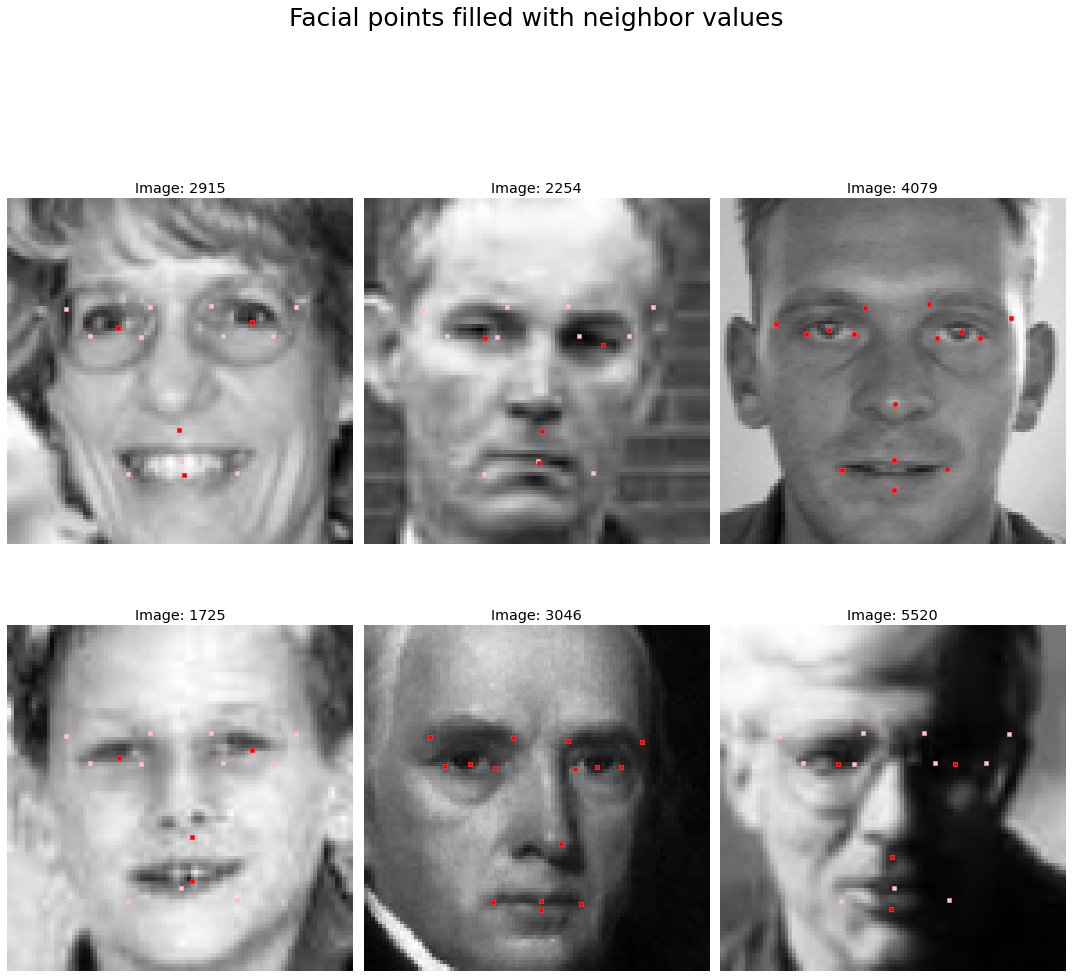

In [0]:
# fill in using median 
imp_median = SimpleImputer(missing_values = np.nan,strategy='median')
y_train_median = imp_median.fit_transform(y_train)
y_dev_median = imp_median.fit_transform(y_dev)
show_multiple_samples(X_train,y_train, y_train_median, 6, fig_title="Facial points filled with neighbor values")

## Fill in missing values using median

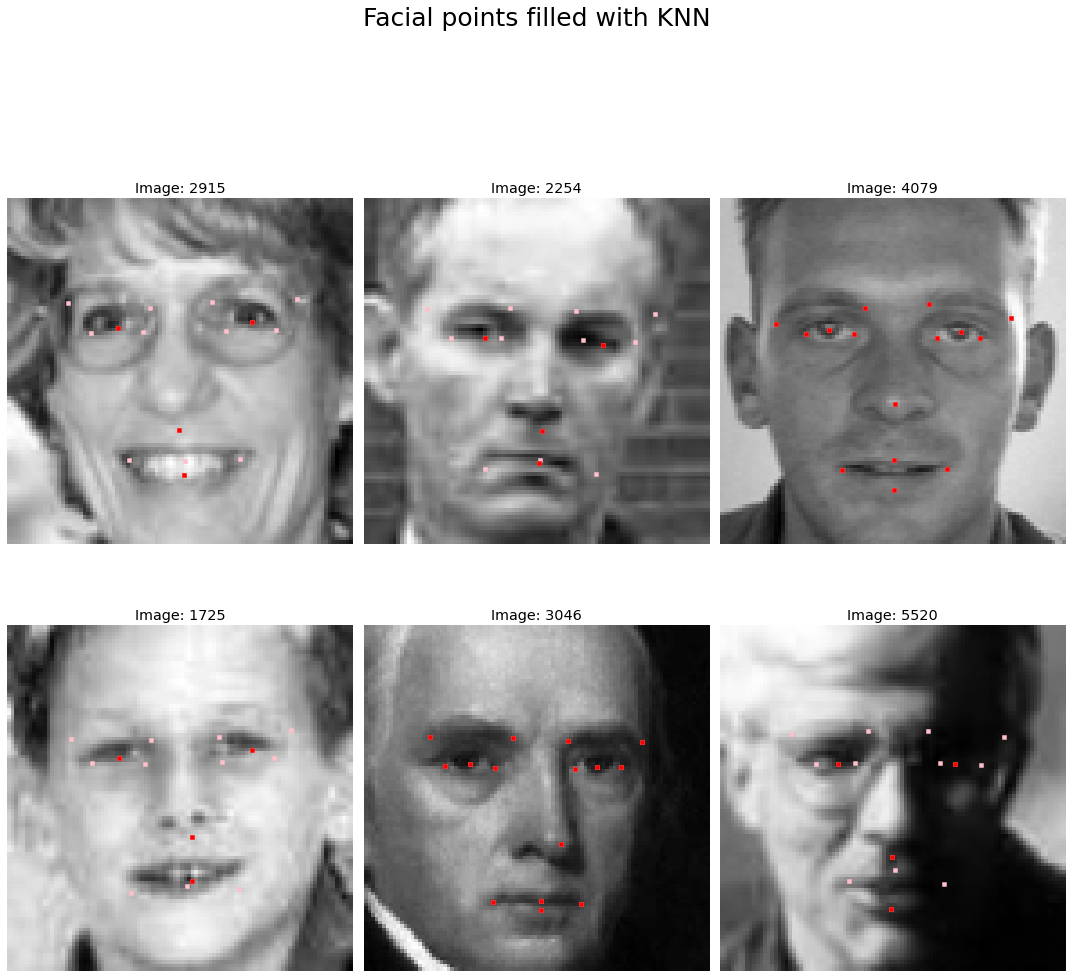

In [0]:
# using KNN function to fill in missing values using KNN
knn_imputer = KNNImputer(n_neighbors=9)
y_train_knn = knn_imputer.fit_transform(y_train)
y_dev_knn = knn_imputer.fit_transform(y_dev)
show_multiple_samples(X_train,y_train, y_train_knn, 6, fig_title="Facial points filled with KNN")

# 3. Data Augmentation

Keras provides a convinient API, `ImageDataGenerator`, to handle provides data augmentation. However it only applies transformation to the data not the landmarks. Therefore, we created a new class `FacialPointImageDataGenerator` to handle this issue.

In [0]:
class FacialPointImageDataGenerator(keras.utils.Sequence):
  '''FacialPointImageDataGenerator'''
  def __init__(self, X_data, y_data,horizontal_flip_prob=0, horizontall_flip_label=None,
               horizontal_shift_range=0.1, horizontal_shift_prob=0,
               shift_range = 0, 
               affine_transformation_prob = 0,
               to_fit=True, batch_size=32, image_size=(96,96), n_channels=1,
               shuffle=True, 
               preprocess_fn=None,
               convertToRGB=False):
    self.to_fit = to_fit
    self.batch_size = batch_size
    self.image_size = image_size
    self.shuffle = shuffle
    self.horizontal_flip_prob = horizontal_flip_prob
    self.horizontal_center = image_size[0]//2;
    self.horizontal_flip_batch_size = int(horizontal_flip_prob * batch_size)
    # need to update the labels if we flip the image horizontally
    # for example left_eye_center_x becomes right_eye_center_x
    self.horizontal_flip_label = {"orig" : [0, 1, 4, 5, 6, 7, 12, 13, 14, 15, 22, 23],
                  "new"  : [2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25]} if  horizontall_flip_label is None else horizontall_flip_label

    self.horizontal_flip_fn = np.vectorize(self.horizontal_flip)
    self.shift_range = shift_range
    self.w_shift_max = int(image_size[0] * shift_range)
    self.h_shift_max = int(image_size[1] * shift_range)
    self.affine_transformation_prob = affine_transformation_prob
    

    self.y_data = y_data
    self.preprocess_fn = preprocess_fn 
    self.convertToRGB = convertToRGB

    if self.convertToRGB:
      self.X_data = np.repeat(X_data,3,axis=-1)
      if preprocess_fn is not None:
        self.X_data = preprocess_fn(self.X_data)
    else:
      self.X_data = X_data
    self.on_epoch_end()

  #helpfer function for performing horizontal flip
  @staticmethod
  def horizontal_flip(element ,center):
    if element < center:
      element = center + (center - element)
    else:
      element = center - (element - center)
    return element
  
  #helpfer function for performing affine transformation
  def transform_image(self, X_data, y_data):
      translation = (np.random.uniform(-1*self.w_shift_max, self.w_shift_max),
                    np.random.uniform(-1*self.h_shift_max, self.h_shift_max))
      
      transformation_matrix = AffineTransform(
            translation=translation
      )

      X_transformed = transform.warp(X_data, transformation_matrix, mode="edge")
      y_data[::2] += -translation[0]
      y_data[1::2] += -translation[1]
      return (X_transformed, y_data)

  def __len__(self):
    '''Number of batches per epoch'''
    return self.X_data.shape[0] // self.batch_size
  
  def on_epoch_end(self):
    '''Called at the end of every epoch. Shuffle indices?'''
    self.indexes = np.arange(self.X_data.shape[0])
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __getitem__(self, index):
    '''Generate one batch of data'''
    #generate indexes
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    #get the data
    X_batch = self.X_data[indexes]
    y_batch = self.y_data[indexes]

    #handle horizontal flip
    if self.horizontal_flip_prob > 0:
      horizontal_flip_index = np.random.choice(self.batch_size, self.horizontal_flip_batch_size, replace=False)
      X_batch[horizontal_flip_index] = X_batch[horizontal_flip_index, :, ::-1,:]
      for index in horizontal_flip_index:
        target_y = y_batch[index]
        target_y_rotated = self.horizontal_flip_fn(target_y, self.horizontal_center)
        target_y_rotated[1::2] = target_y[1::2]
        ## need to flip indicies
        y_batch_orig = target_y_rotated[self.horizontal_flip_label["orig"]]
        target_y_rotated[self.horizontal_flip_label["orig"]] = target_y_rotated[self.horizontal_flip_label["new"]]
        target_y_rotated[self.horizontal_flip_label["new"]]  = y_batch_orig   
        y_batch[index] = target_y_rotated

    #handle affine transformation
    if self.affine_transformation_prob > 0:
      for index in range(self.batch_size):
        X_batch[index], y_batch[index] = self.transform_image(X_batch[index],y_batch[index])
    
    return X_batch, y_batch


## Horizontal flip

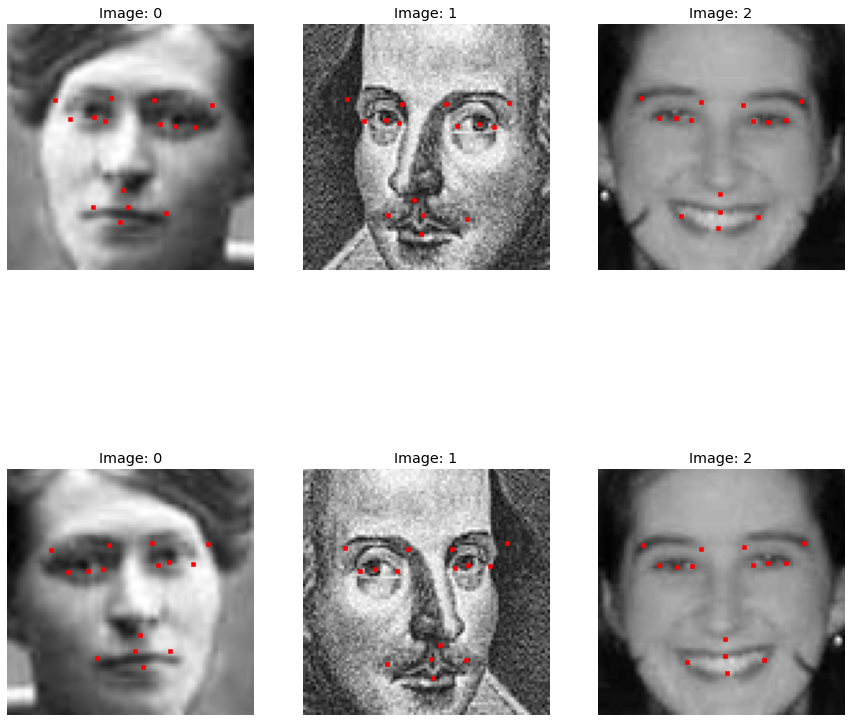

In [0]:
params = {
    'X_data': X_train,
    'y_data': y_train_knn,
    'shuffle': False
}

train_datagen_normal = FacialPointImageDataGenerator(horizontal_flip_prob=0,**params)
train_datagen_flipped = FacialPointImageDataGenerator(horizontal_flip_prob=1.0,**params)

X_normal, y_normal = train_datagen_normal[0]
X_flipped, y_flipped = train_datagen_flipped[0]
_,axes = plt.subplots(2,3)

for i in range(3):
  show_image_with_key_points(X_normal[i], y_normal[i], i, axes[0,i])
  show_image_with_key_points(X_flipped[i], y_flipped[i], i, axes[1,i])

In [0]:
y_normal[0]

array([65.03111 , 39.383427, 33.525494, 35.88281 ,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan, 44.7274  , 64.23787 ,       nan,       nan,
             nan,       nan,       nan,       nan, 43.677277, 76.84013 ],
      dtype=float32)

## shift

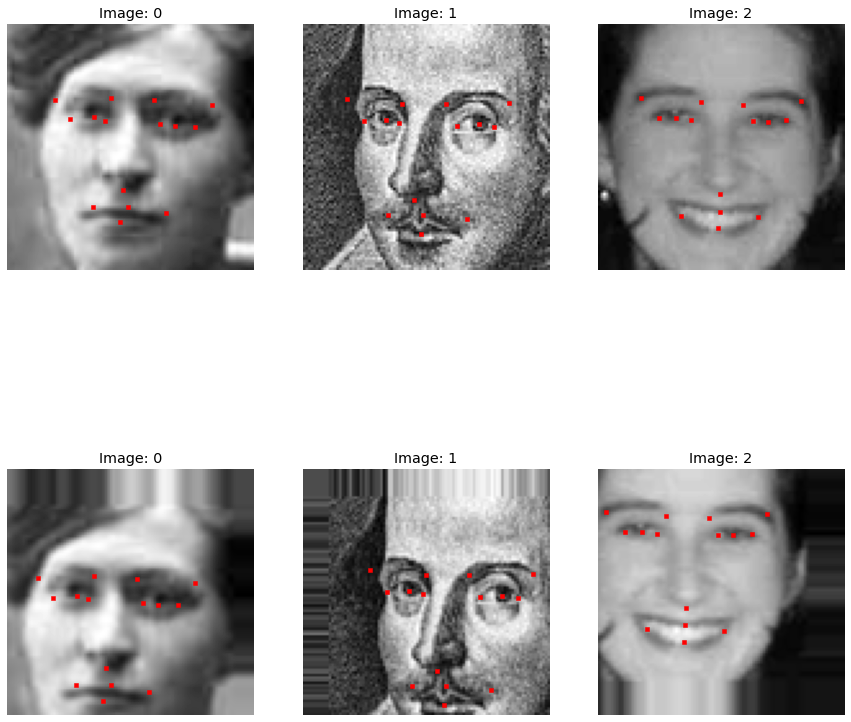

In [0]:
params = {
    'X_data': X_train,
    'y_data': y_train_knn,
    'shift_range': 0.15,
    'shuffle': False
}

train_datagen_normal = FacialPointImageDataGenerator(affine_transformation_prob=0.0,**params)
train_datagen_flipped = FacialPointImageDataGenerator(affine_transformation_prob=1.0,**params)

X_normal, y_normal = train_datagen_normal[0]
X_flipped, y_shifted = train_datagen_flipped[0]
_,axes = plt.subplots(2,3)


for i in range(3):
  show_image_with_key_points(X_normal[i], y_normal[i], i, axes[0,i])
  show_image_with_key_points(X_flipped[i], y_shifted[i], i, axes[1,i])


# 4. Training various models

## Helper function & generators for models

In [0]:
# Helper function for displaying loss and val_loss
def plot_history(history, name):
  loss = history['loss']
  val_loss = history['val_loss']
  plt.plot(figsize=(15,10))
  plt.plot(loss,"--",linewidth=3,label="train:"+name)
  plt.plot(val_loss,linewidth=3,label="val:"+name)
  plt.yscale("log")
  plt.xlabel("epoch")
  plt.ylabel("log loss")
  plt.legend()
  plt.grid(True)

train_datagen_knn_augmented = FacialPointImageDataGenerator(
    X_data= X_train,
    y_data= y_train_knn,
    affine_transformation_prob=0.5,
    horizontal_flip_prob=0.5,
    convertToRGB=False)

validation_datagen_knn_augmented = FacialPointImageDataGenerator(
    X_data= X_dev,
    y_data= y_dev_knn,
    affine_transformation_prob=0.0,
    horizontal_flip_prob=0.,
    convertToRGB=False)


## LeNet-5

In [0]:
def create_naive_LeNet5_model(input_shape):
  print(f"Initializing LeNet5 model with input-size: {input_shape}")
  model = keras.Sequential()
  model.add(keras.layers.InputLayer(input_shape))
  model.add(keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=120, activation='relu'))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(units=84, activation='relu'))
  model.add(keras.layers.Dense(units=30))
  return model

LeNet5_model = create_naive_LeNet5_model(X_train.shape[1:])
LeNet5_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
LeNet5_result = LeNet5_model.fit_generator(generator = train_datagen_knn_augmented,
                                           validation_data = validation_datagen_knn_augmented,
                                           epochs=40)

Initializing LeNet5 model with input-size: (96, 96, 1)
Epoch 1/40
187/187 [==============================] - 3s 18ms/step - loss: 300.3066 - mae: 12.5388 - val_loss: 90.8259 - val_mae: 7.1054
Epoch 2/40
187/187 [==============================] - 3s 17ms/step - loss: 112.3354 - mae: 8.0647 - val_loss: 78.4486 - val_mae: 6.7161
Epoch 3/40
187/187 [==============================] - 3s 18ms/step - loss: 61.1405 - mae: 5.8239 - val_loss: 41.5389 - val_mae: 5.2679
Epoch 4/40
187/187 [==============================] - 3s 17ms/step - loss: 29.6697 - mae: 4.0075 - val_loss: 78.3654 - val_mae: 7.9622
Epoch 5/40
187/187 [==============================] - 3s 17ms/step - loss: 22.4925 - mae: 3.4556 - val_loss: 69.4545 - val_mae: 7.3818
Epoch 6/40
187/187 [==============================] - 3s 17ms/step - loss: 18.4329 - mae: 3.0990 - val_loss: 112.0090 - val_mae: 9.5721
Epoch 7/40
187/187 [==============================] - 3s 17ms/step - loss: 16.0824 - mae: 2.8479 - val_loss: 84.0098 - val_mae: 8.2

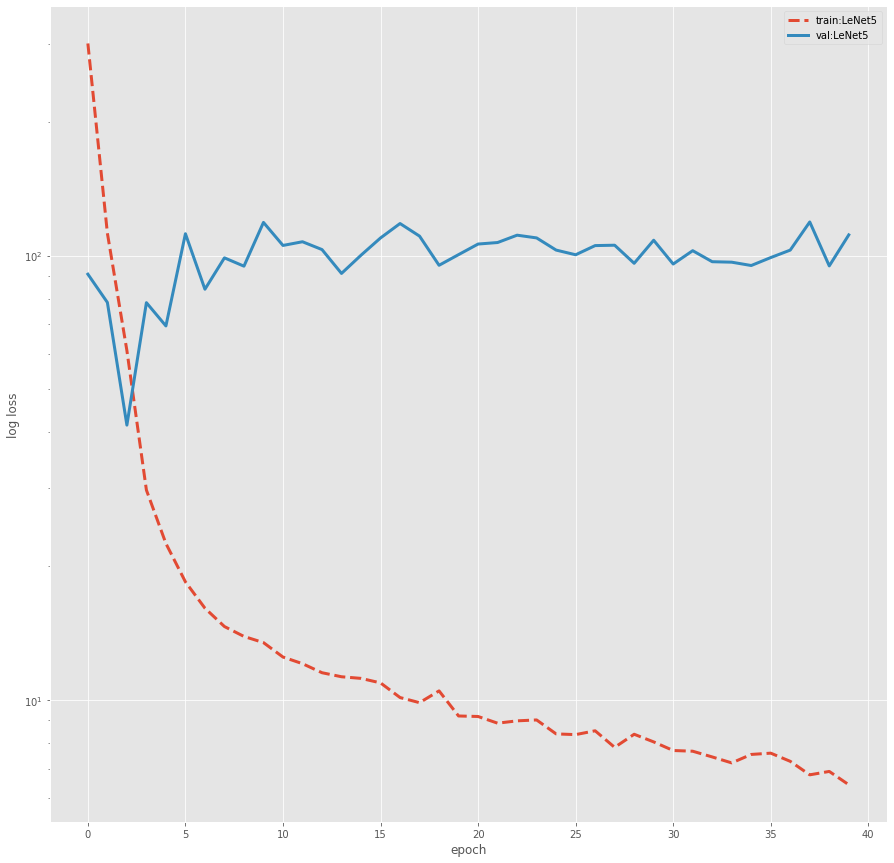

In [0]:
plot_history(LeNet5_result.history, "LeNet5")

## VGG-16 with transfer learning(image-net) 

- Our dataset consists of few thousand entries. We can only learn small set of common features from this dataset. The idea behind transfer learning is to use an existing model that has been already trained on far more data as start a starting point and use the features that model has learned. Specifically, we are borrowing the convolutional neural network layers which were trained to extract features for much larger dataset. In this model, we will be using the model that has been trained on a dataset from [ImageNet](http://image-net.org) which has over 1.4 million images. 


In [0]:

def create_vgg16_model_with_transfer_learning(input_shape):
  # convert the grayscale input layer to rgb channels
  # single_channel_input = keras.layers.Input(shape=input_shape)
  # single_channel_concat = keras.layers.concatenate([single_channel_input,single_channel_input,single_channel_input])

  #load VGG16 model pre-trained with imagenet
  pre_trained_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
  #pre_trained_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False)
  #output = pre_trained_model(single_channel_concat)
  last_layer = pre_trained_model.get_layer("block4_pool")
  #freeze convolutional layers
  #for layer in pre_trained_model.layers:
  #  layer.trainable = False

  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_layer.output)
  #x = layers.Flatten()(output)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)                  
  x = layers.Dense  (30)(x) 
  model = Model(pre_trained_model.input, x) 
  #model = Model(single_channel_input, x)
  return model
  
#VGG16_transfer = create_vgg16_model_with_transfer_learning((96,96,3))
VGG16_transfer = create_vgg16_model_with_transfer_learning((96,96,3))
VGG16_transfer.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
VGG16_transfer.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0   

In [0]:
train_datagen_knn_augmented = FacialPointImageDataGenerator(
    X_data= X_train,
    y_data= y_train_knn,
    affine_transformation_prob=0.0,
    horizontal_flip_prob=0.0,
    convertToRGB=True,
    batch_size=256,
    preprocess_fn = keras.applications.vgg16.preprocess_input
    )

validation_datagen_knn_augmented = FacialPointImageDataGenerator(
    X_data= X_dev,
    y_data= y_dev_knn,
    affine_transformation_prob=0.0,
    horizontal_flip_prob=0.,
    convertToRGB=True,
    batch_size=256,
    preprocess_fn = keras.applications.vgg16.preprocess_input)

VGG16_result = VGG16_transfer.fit_generator(generator = train_datagen_knn_augmented,
                                           validation_data = validation_datagen_knn_augmented,
                                           epochs=40)


Epoch 1/40
23/23 [==============================] - 18s 775ms/step - loss: 60255.9062 - mae: 82.2685 - val_loss: 363.8464 - val_mae: 15.5695
Epoch 2/40
23/23 [==============================] - 17s 747ms/step - loss: 269.5164 - mae: 12.8997 - val_loss: 374.4943 - val_mae: 16.1520
Epoch 3/40
23/23 [==============================] - 18s 792ms/step - loss: 180.9139 - mae: 10.5952 - val_loss: 332.1244 - val_mae: 15.4816
Epoch 4/40
23/23 [==============================] - 18s 785ms/step - loss: 142.7751 - mae: 9.3664 - val_loss: 191.4390 - val_mae: 11.4587
Epoch 5/40
23/23 [==============================] - 18s 782ms/step - loss: 104.7256 - mae: 8.0203 - val_loss: 101.9636 - val_mae: 8.1637
Epoch 6/40
23/23 [==============================] - 18s 782ms/step - loss: 81.1161 - mae: 7.0661 - val_loss: 55.6896 - val_mae: 5.6079
Epoch 7/40
23/23 [==============================] - 18s 787ms/step - loss: 74.0958 - mae: 6.7482 - val_loss: 81.9296 - val_mae: 6.3614
Epoch 8/40
23/23 [==================